In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import joblib

In [2]:
# Load dataset and view it
df = pd.read_csv("/Users/apple/Desktop/Methanol Synthesis Project/data/synthetic_methanol_synthesis_data.csv")
df.head(10)

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Overall Yield
0,480.630829,91.621243,18.100214,13.236934,0.390921
1,550.991879,68.001329,6.006925,24.561671,0.526929
2,516.840923,70.676729,17.977576,19.551870,0.531930
3,545.346518,95.531033,15.972852,16.805256,0.565548
4,570.798951,54.649330,17.036762,22.303915,0.750000
5,526.849587,50.915276,7.689944,15.740624,0.525996
6,523.112046,108.978748,18.616806,16.563335,0.525677
7,480.205113,86.716202,11.200205,11.226374,0.263277
8,499.843898,145.343874,18.784522,16.864358,0.474244
9,522.988250,146.015354,14.929243,21.747529,0.510466


## __Exploratory Data Analysis__

Explore the data!

In [3]:
# check for missing values
df.isnull().sum().sum()

np.int64(0)

In [4]:
# Summary statistics of dataset
df.describe()

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Overall Yield
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,522.586448,99.929507,12.504039,19.962724,0.477861
std,28.909005,29.112961,4.355903,5.728142,0.136494
min,473.018492,50.011425,5.000328,10.000665,0.054173
25%,497.372571,74.746197,8.685649,15.004785,0.475069
50%,522.505259,99.587989,12.575538,19.932608,0.513855
75%,548.072253,125.412249,16.330333,24.927440,0.543400
max,572.977945,149.983605,19.999106,29.993364,0.750000


From the summary statistics, columns of dataset seem close to symmetrical (i.e mean is almost equals to median) with moderate variability, and the Overall yield column is slightly skewed to the left(i.e median>mean), but lets plot histograms to view distributions properly so we can be sure

### __Univariate Data Analyses__

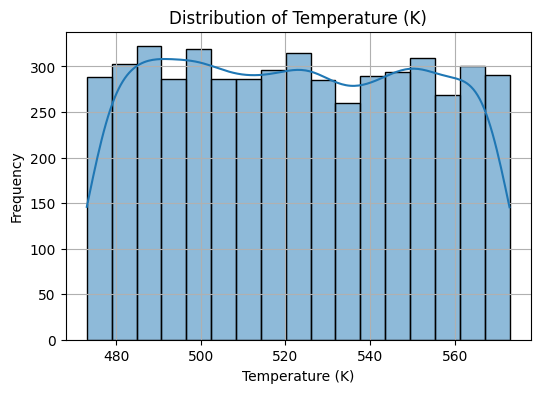

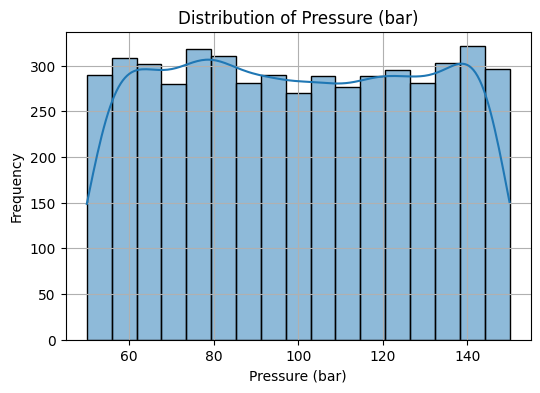

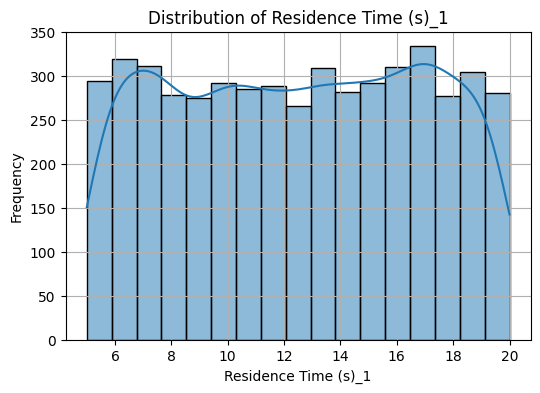

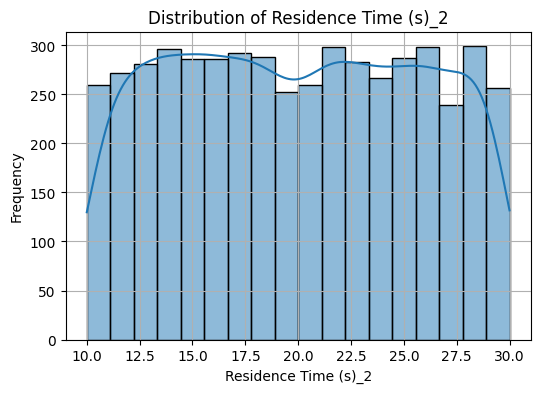

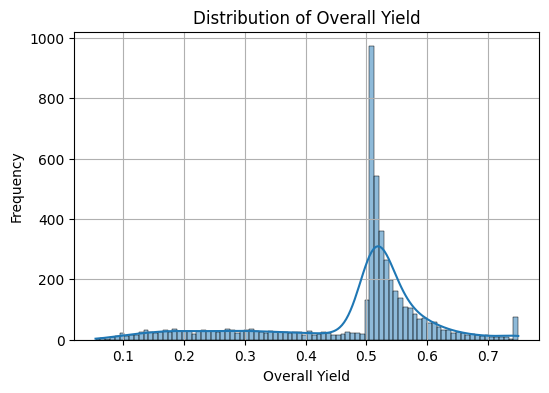

In [5]:
# Plotting histograms of columns to show the distributions
def plot_columns(df):
    for column in df.columns:
        plt.figure(figsize=(6,4))
        sns.histplot(df[column],kde=True)
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
plot_columns(df)


Features columns show multimodal distribution due to random generation but Overall yield column is skewed to the left with potential outliers, so lets check for outliers using boxplot 

### __Outlier Detection__

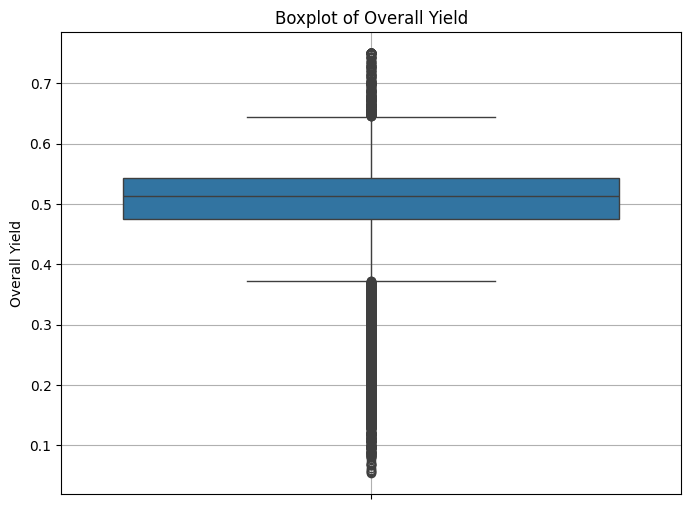

In [6]:
# Plotting the boxplot to view the possible outliers
def plot_boxplot(df):
    plt.figure(figsize=(8,6))
    sns.boxplot(df['Overall Yield'])
    plt.title("Boxplot of Overall Yield")
    plt.grid(True)
    plt.show()

plot_boxplot(df)    

Overall yield column contains outliers, but these outliers are real process behaviours such as maintenance failure, abnormal condition or valuable edge cases so we shall keep the outliers.

After the univariate analysis, we can see that the features are multimodal and the overall yield is left skewed with outliers. 
Let us use these insight to engineer features that could make relationship more linear and improve model performance

<u>Note</u>: Outliers are maintained because  they represent real-life process behaviours

### __Feature Engineering__

In [7]:
# Feature Engineering 
# yield feature engineering. (Box-cox here helps make the skewed distribution normal)
def yield_features(df,save_path='/Users/apple/Desktop/Methanol Synthesis Project/objects/yield_boxcox_transformer.pkl'):
    pt = PowerTransformer(method='box-cox', standardize=False)
    df['Yield_boxcox'] = pt.fit_transform(df[['Overall Yield']])

    # Save the fitted transformer for future use
    joblib.dump(pt, save_path)
    return df

yield_features(df)

# temperature feature engineering. Capture polynomial relationships
def temp_features(df):
    df['Temp_square'] = np.square(df['Temperature (K)'])
    return df

temp_features(df)

# pressure feature engineering. Capture polynomial relationships
def press_features(df):
    df['Press_square'] = np.square(df['Pressure (bar)'])
    return df

press_features(df)

# residence time feature engineering. Capture realtionship with total time taken and ratios of different resident times
def res_times_features(df):
    df['Total res time'] = df['Residence Time (s)_1']+df['Residence Time (s)_2']
    df['Res time ratio'] = df['Residence Time (s)_1']/df['Residence Time (s)_2']
    return df

res_times_features(df) 

# mixture of features feature engineering. Explore relationship of features together with yield
def mix_features(df):
    df['Pressure/Temp'] = df['Pressure (bar)']/df['Temperature (K)']
    df['Temp_Pressure'] = df['Temperature (K)']*df['Pressure (bar)']
    df['Temp/Total time'] = df['Temperature (K)']/df['Total res time']
    df['Press/Total time'] = df['Pressure (bar)']/df['Total res time']
    return df

mix_features(df) 

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Overall Yield,Yield_boxcox,Temp_square,Press_square,Total res time,Res time ratio,Pressure/Temp,Temp_Pressure,Temp/Total time,Press/Total time
0,480.630829,91.621243,18.100214,13.236934,0.390921,-0.413251,231005.993725,8394.452116,31.337148,1.367402,0.190627,44035.993833,15.337414,2.923726
1,550.991879,68.001329,6.006925,24.561671,0.526929,-0.354371,303592.050971,4624.180698,30.568596,0.244565,0.123416,37468.179862,18.024769,2.224549
2,516.840923,70.676729,17.977576,19.551870,0.531930,-0.351847,267124.539836,4995.200005,37.529446,0.919481,0.136748,36528.625800,13.771611,1.883234
3,545.346518,95.531033,15.972852,16.805256,0.565548,-0.334214,297402.824458,9126.178258,32.778108,0.950468,0.175175,52097.516165,16.637523,2.914477
4,570.798951,54.649330,17.036762,22.303915,0.750000,-0.216622,325811.442691,2986.549253,39.340676,0.763846,0.095742,31193.780164,14.509129,1.389130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,549.572426,89.599971,7.375668,21.468288,0.524405,-0.355635,302029.850970,8028.154740,28.843956,0.343561,0.163036,49241.673203,19.053296,3.106369
4996,505.386836,134.553462,5.904387,26.727598,0.213350,-0.462336,255415.854225,18104.634043,32.631984,0.220910,0.266239,68001.548287,15.487469,4.123361
4997,479.586455,129.710178,5.916101,12.938788,0.087962,-0.478757,230003.167585,16824.730310,18.854889,0.457238,0.270463,62207.244474,25.435655,6.879392
4998,566.517555,105.306062,11.081867,25.971894,0.563470,-0.335338,320942.140189,11089.366601,37.053762,0.426687,0.185883,59657.732527,15.289070,2.841980


### __Bivariate Data Analyses__

Here we evaluate the relationships between our features and our two target variables (i.e the Overall yield and the Yield_Boxcox) to check which target would be better to use

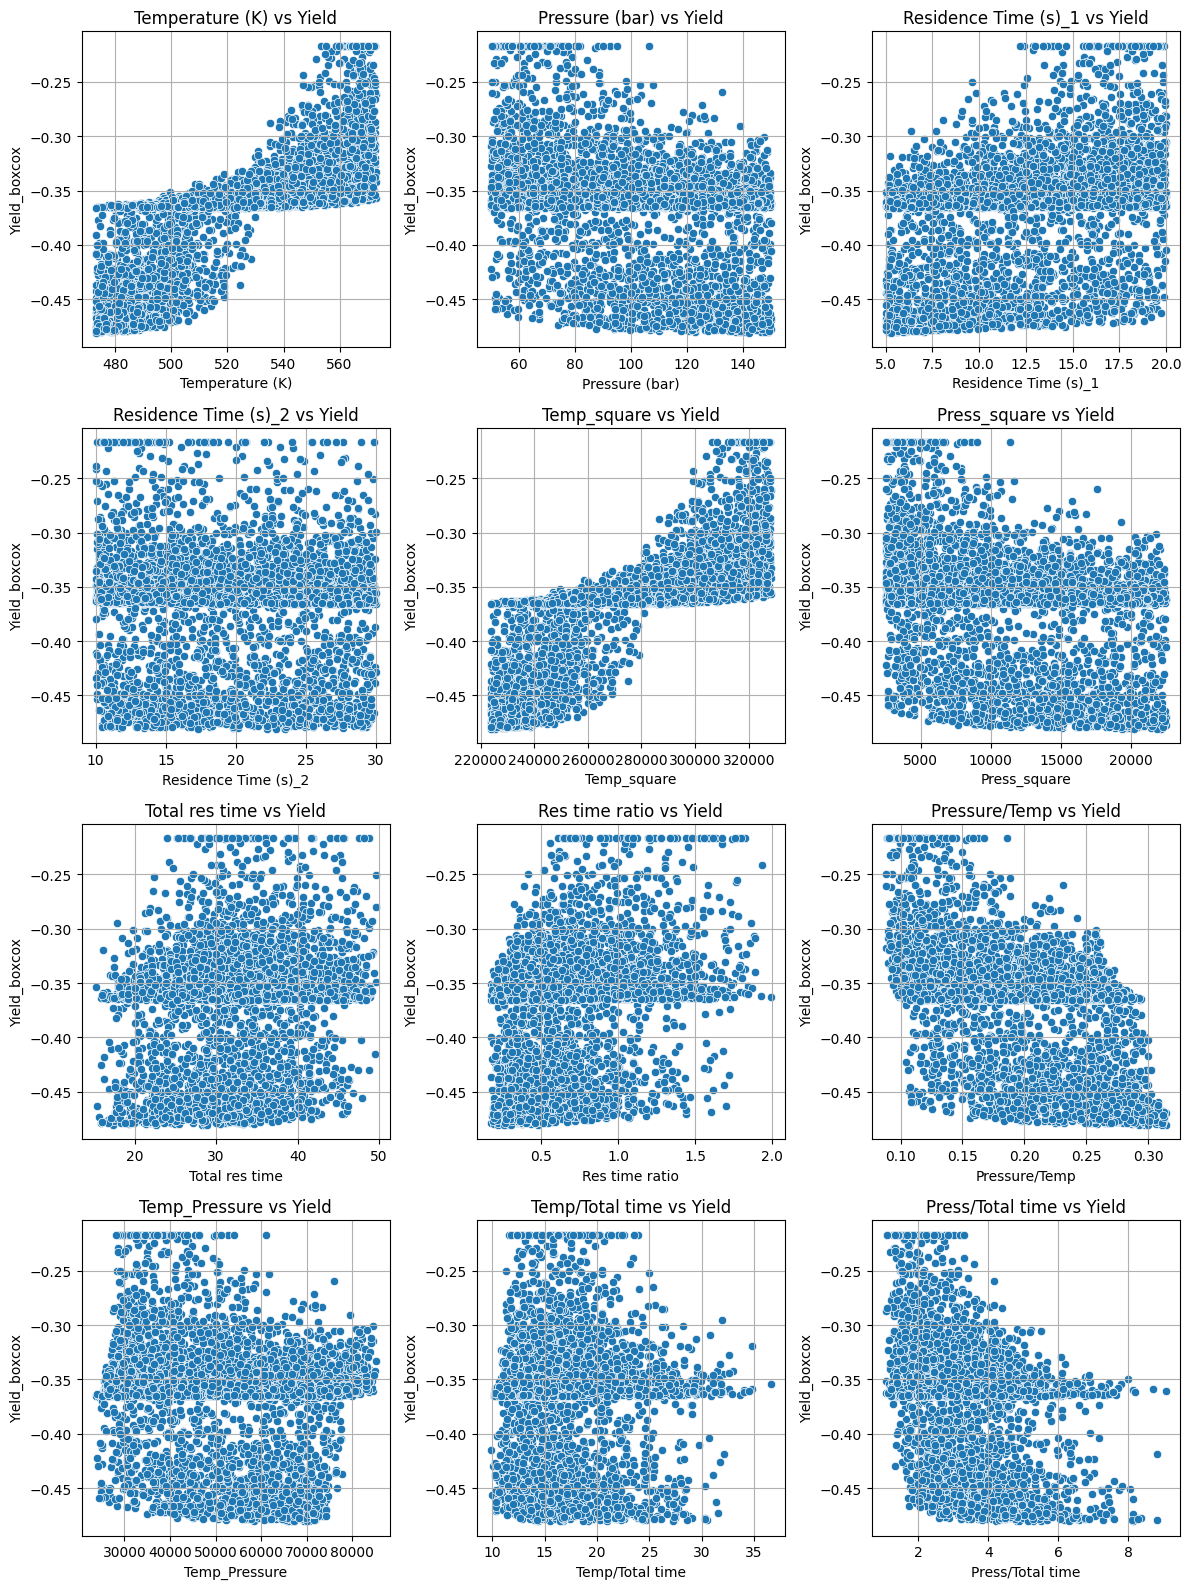

In [8]:
# Writing the function
def plot_scatterplot(df,column=df['Yield_boxcox']):
    features = ['Temperature (K)', 'Pressure (bar)', 'Residence Time (s)_1',
        'Residence Time (s)_2', 'Temp_square',
        'Press_square', 'Total res time', 'Res time ratio', 'Pressure/Temp',
        'Temp_Pressure', 'Temp/Total time', 'Press/Total time']
    fig,axes = plt.subplots(4,3,figsize=(12,16))
    axes = axes.flatten()            
    for i,feature in enumerate(features):
        sns.scatterplot(x=df[feature], y=df['Yield_boxcox'],ax=axes[i])
        axes[i].set_title(f'{feature} vs Yield')
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()  

# Lets compare the trends of features with the box-cox of the yield
plot_scatterplot(df,df['Overall Yield'])      

We performed scatter plots of features against `Overall Yield` to visualize their relationships and trends, as it represents the raw process outcome and is more interpretable in the context of methanol synthesis. Since the Box-Cox transformation (`Yield_boxcox`) is monotonic, it preserves these relationships, and scatter plots with `Yield_boxcox` would show the same trends on a different scale. The transformation’s purpose is to normalize the left-skewed distribution of `Overall Yield` to meet regression assumptions (e.g., normality of residuals), which we confirm with a histogram of `Yield_boxcox`. We will use `Yield_boxcox` as the target for modeling due to its normalized distribution.

<Axes: xlabel='Yield_boxcox', ylabel='Count'>

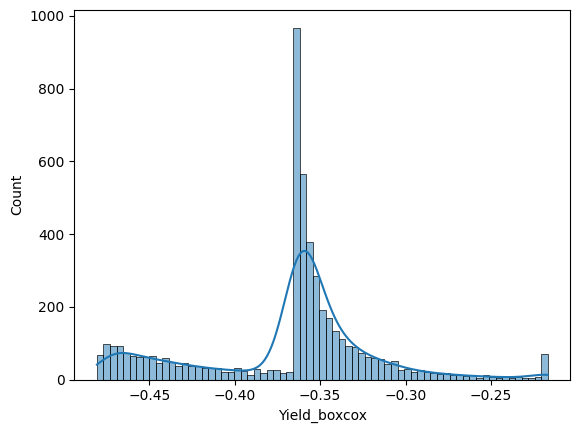

In [9]:
# View distribution of Box-cox Yield to verify normalization
sns.histplot(df['Yield_boxcox'],kde=True)

Next, lets proced to correlation analysis

### __Correlation Analysis__

In [10]:
# Correlation with Log_Yield
def correlation(df):
    features = ['Temperature (K)', 'Pressure (bar)', 'Residence Time (s)_1',
        'Residence Time (s)_2', 'Temp_square',
        'Press_square', 'Total res time', 'Res time ratio', 'Pressure/Temp',
        'Temp_Pressure', 'Temp/Total time', 'Press/Total time', 'Yield_boxcox']
    correlation = df[features].corr(method='spearman')
    print("Correlation with Yield:\n",correlation['Yield_boxcox'])

correlation(df)    

Correlation with Yield:
 Temperature (K)         0.880891
Pressure (bar)         -0.289903
Residence Time (s)_1    0.336304
Residence Time (s)_2   -0.053171
Temp_square             0.880891
Press_square           -0.289903
Total res time          0.150348
Res time ratio          0.294222
Pressure/Temp          -0.443107
Temp_Pressure          -0.129683
Temp/Total time         0.055735
Press/Total time       -0.329629
Yield_boxcox            1.000000
Name: Yield_boxcox, dtype: float64


From the correlation analysis, we observe signs of multicollinearity among some features and identify others with very weak linear correlation with the target variable. As a result, we will drop highly multicollinear features to avoid redundancy and may remove features with correlation below ±0.1 if they show no added value during modeling.

In [11]:
# dropping redundant and less correlated features
def drop_redundant_features(df):
    df = df.drop(['Temp_square','Press_square'],axis='columns')
    return df

df = drop_redundant_features(df)    

df.head()

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Overall Yield,Yield_boxcox,Total res time,Res time ratio,Pressure/Temp,Temp_Pressure,Temp/Total time,Press/Total time
0,480.630829,91.621243,18.100214,13.236934,0.390921,-0.413251,31.337148,1.367402,0.190627,44035.993833,15.337414,2.923726
1,550.991879,68.001329,6.006925,24.561671,0.526929,-0.354371,30.568596,0.244565,0.123416,37468.179862,18.024769,2.224549
2,516.840923,70.676729,17.977576,19.551870,0.531930,-0.351847,37.529446,0.919481,0.136748,36528.625800,13.771611,1.883234
3,545.346518,95.531033,15.972852,16.805256,0.565548,-0.334214,32.778108,0.950468,0.175175,52097.516165,16.637523,2.914477
4,570.798951,54.649330,17.036762,22.303915,0.750000,-0.216622,39.340676,0.763846,0.095742,31193.780164,14.509129,1.389130


In [12]:
# Arranging dataset for modelling
features = ['Temperature (K)', 'Pressure (bar)', 'Residence Time (s)_1',
       'Residence Time (s)_2',
       'Total res time', 'Res time ratio', 'Pressure/Temp', 'Temp_Pressure',
       'Temp/Total time', 'Press/Total time']
targets = ['Overall Yield', 'Yield_boxcox']

df = df[features+targets]
df.head()

,Temperature (K),Pressure (bar),Residence Time (s)_1,Residence Time (s)_2,Total res time,Res time ratio,Pressure/Temp,Temp_Pressure,Temp/Total time,Press/Total time,Overall Yield,Yield_boxcox
0,480.630829,91.621243,18.100214,13.236934,31.337148,1.367402,0.190627,44035.993833,15.337414,2.923726,0.390921,-0.413251
1,550.991879,68.001329,6.006925,24.561671,30.568596,0.244565,0.123416,37468.179862,18.024769,2.224549,0.526929,-0.354371
2,516.840923,70.676729,17.977576,19.551870,37.529446,0.919481,0.136748,36528.625800,13.771611,1.883234,0.531930,-0.351847
3,545.346518,95.531033,15.972852,16.805256,32.778108,0.950468,0.175175,52097.516165,16.637523,2.914477,0.565548,-0.334214
4,570.798951,54.649330,17.036762,22.303915,39.340676,0.763846,0.095742,31193.780164,14.509129,1.389130,0.750000,-0.216622


Data is now ready for modelling, download prepared dataset below for modelling

<u>Note</u>: Scaling is deferred till model selection

In [13]:
df.to_csv('/Users/apple/Desktop/Methanol Synthesis Project/data/prepared_yield_dataset.csv', index=False)